In [39]:
import torch 
from torch import Tensor 
import numpy as np
import math
import matplotlib.pyplot as plt

## Data Generation

In [40]:
data = torch.FloatTensor(1000,2).uniform_(0,1)
distance = torch.sqrt(torch.pow(data[:, 0], 2) + torch.pow(data[:,1],2)).view(-1,1)
radius = 1 / math.sqrt(2 * math.pi)
inside = distance.clone().apply_(lambda x : 1 if x < radius else  -1)
outside = distance.clone().apply_(lambda x : 1 if x > radius else  -1)

target = torch.cat((inside, outside),1)

In [41]:
data


 0.4142  0.8499
 0.7435  0.0881
 0.5315  0.0151
       ⋮        
 0.2972  0.2211
 0.7841  0.4328
 0.1632  0.4421
[torch.FloatTensor of size 1000x2]

In [42]:
distance



 0.9454
 0.7487
 0.5317
   ⋮    
 0.3704
 0.8956
 0.4712
[torch.FloatTensor of size 1000x1]

In [43]:
radius

0.3989422804014327

In [44]:
target



   -1     1
   -1     1
   -1     1
     ⋮      
    1    -1
   -1     1
   -1     1
[torch.FloatTensor of size 1000x2]

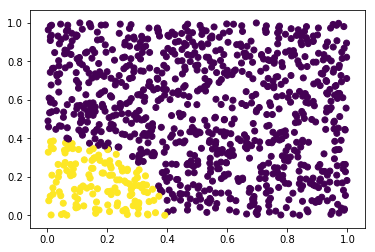

In [45]:
plt.scatter(data[:,0], data[:,1], c=inside)
plt.show()

## ReLu

In [46]:
class Relu:
    
    def forward(self, X):   
        self.x = X
        return X.clamp(min=0)
    
    def backward(self, dz):
        output = self.x.clone()
        output[output > 0] = 1
        output[output < 0] = 0
        return output * dz
    

## Tanh Module


In [47]:
class Tanh:
    
    def forward(self, X):
        self.output = Tensor.tanh(X)
        return self.output;

    def backward(self, dz):
        return (1.0 - Tensor.pow(self.output,2)) * dz
        

In [48]:
def sigma(x):
    return x.tanh()

def dsigma(x):
    return 4 * (x.exp() + x.mul(-1).exp()).pow(-2)

## LossMSE Module

In [49]:
class LossMSE: 
        
    def __init__(self, activation_func):
        self.activation_func = activation_func
        
    def forward(self, t, x):
        output =  self.activation_func.forward(x)
        return torch.mean((output - t).pow(2))
    
    def backward(self, t, x):
        dloss = 2 * (x - t)
        return  self.activation_func.backward(dloss)

## Linear Module

In [50]:
class Linear:
    
    def __init__(self, input_size ,hidden_nodes):    
        
        # Initialize weight, bias xavie initializer
        self.w = Tensor(hidden_nodes, input_size).normal_() / math.sqrt(input_size)
        self.b = Tensor(hidden_nodes).normal_() / math.sqrt(input_size)
        
    def forward(self, x):
        self.x = x
        s = x.mm(self.w.t()) + self.b
        return s
        
    def backward(self, dz, lambda_):
        
        dx = dz.mm(self.w)
        dw = self.x.t().mm(dz)
        db = dz.t().sum(1).squeeze_()
        
        self.dw = dw
#         print(dw.t().mm(dw).sum())
        # update weight and bias
        self.w = self.w - lambda_ * dw
        self.b = self.b - lambda_ * db
                
        return dx
        
    def params(self):
        return (self.w, self.b, self.dw)
    
    
    

## Sequential Module

In [54]:
class Sequential:
    
    def __init__(self, layer_modules, activation_func):
        
        self.layer_modules = layer_modules
        self.activation_func = activation_func

    def forward(self, x_input):
        
        result = x_input
        
        # hidden layer
        for i in range(len(self.layer_modules) - 1): 
            result = self.layer_modules[i].forward(result)
            result = self.activation_func.forward(result)
      

        # output layer
        result = self.layer_modules[-1].forward(result)
        
        return result
    
    def backward(self, dz, lambda_):
    
        for i in range(len(self.layer_modules) - 1, 0, -1):
            dz = self.layer_modules[i].backward(dz,lambda_) #* self.activation_func.backward(dz)
            dz = self.activation_func.backward(dz)
        
        dz = self.layer_modules[0].backward(dz, lambda_)



    
        return dz
    def get_params(self):
        for m in self.layer_modules:
            print('{},{}'.format(m.params()[0], m.params()[1]))


In [55]:
lambda_ =  1e-1/400
train_data, train_target, test_data, test_target = data[0:800,], target[0:800,], data[800:,], target[800:,]
no_iter = 500



modules = list([Linear(2, 25),Linear(25, 25),Linear(25, 25) ,Linear(25, 2)])
# modules = list([Linear(2, 25) ,Linear(25, 2)])


# seq = Sequential(modules, Tanh())
seq = Sequential(modules, Relu())

# Initialize loss function
loss_mse = LossMSE(Tanh())
    

## SGD 
for n in range(no_iter): 
   
    
    # Random sampling
#     randomInt  = np.random.randint(800, size=(1))[0]
#     sample_data = train_data[randomInt, :].view(-1,2)
#     sample_target = train_target[randomInt, :].view(-1,2)
    
    train_loss = 0
    
    for a in range(0,800):
        sample_data = train_data[a, :].view(-1,2)
        sample_target = train_target[a, :].view(-1,2)

        # Forward path
        nn_output = seq.forward(sample_data)

        loss_mse.forward(sample_target,nn_output)

        if a > 300:
            lambda_ = 1e-1/800
        
        # Backward path (update weight and bias)

        dz = loss_mse.backward(sample_target, nn_output)
        seq.backward(dz, lambda_)

        # Compute Loss
        train_loss += loss_mse.forward(train_target,seq.forward(train_data))


    
    # compute train accuracy 
    train_errors = 0
    for i in range(train_data.shape[0]):
        pred = seq.forward(train_data[i,:].view(-1,2)).max(1)[1][0]
        if train_target[i, pred] < 0:
             train_errors += 1
    
    
    # comput test accuracy
    test_errors = 0
    for i in range(test_data.shape[0]):
        
        pred = seq.forward(test_data[i,:].view(-1,2)).max(1)[1][0]
        if test_target[i, pred] < 0: 
             test_errors += 1
   

    # 
    
    print('{:d} train_loss {:.02f} train_error {:.02f}% test_error {:.02f}%'
          .format(n,
                  train_loss,
                  (100 * train_errors) / train_data.size(0),
                  (100 * test_errors) / test_data.size(0)))



/usr/local/lib/python3.6/site-packages/torch/tensor.py:312: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.sub(other)


=====35.61929864436388=====
0 train_loss 858.06 train_error 13.88% test_error 13.50%
=====36.07170260883868=====
1 train_loss 597.30 train_error 13.88% test_error 13.50%
=====36.44156251102686=====
2 train_loss 491.79 train_error 13.88% test_error 13.50%
=====36.71892953850329=====
3 train_loss 445.41 train_error 13.88% test_error 13.50%
=====36.92985958606005=====
4 train_loss 422.92 train_error 13.88% test_error 13.50%
=====37.08901980891824=====
5 train_loss 410.83 train_error 13.88% test_error 13.50%
=====37.210597574710846=====
6 train_loss 403.80 train_error 13.88% test_error 13.50%
=====37.30623500980437=====
7 train_loss 399.37 train_error 13.88% test_error 13.50%
=====37.383183646947145=====
8 train_loss 396.40 train_error 13.88% test_error 13.50%
=====37.447150422260165=====
9 train_loss 394.31 train_error 13.88% test_error 13.50%
=====37.50325649604201=====
10 train_loss 392.77 train_error 13.88% test_error 13.50%
=====37.55265142582357=====
11 train_loss 391.62 train_error 

=====47.54685640335083=====
96 train_loss 390.53 train_error 13.88% test_error 13.50%
=====47.74709936790168=====
97 train_loss 390.61 train_error 13.88% test_error 13.50%
=====47.95015223696828=====
98 train_loss 390.69 train_error 13.88% test_error 13.50%
=====48.15495549328625=====
99 train_loss 390.77 train_error 13.88% test_error 13.50%
=====48.36193220131099=====
100 train_loss 390.85 train_error 13.88% test_error 13.50%
=====48.56924939714372=====
101 train_loss 390.94 train_error 13.88% test_error 13.50%
=====48.77848644182086=====
102 train_loss 391.02 train_error 13.88% test_error 13.50%
=====48.98895218037069=====
103 train_loss 391.10 train_error 13.88% test_error 13.50%
=====49.20170204527676=====
104 train_loss 391.18 train_error 13.88% test_error 13.50%
=====49.41625896655023=====
105 train_loss 391.26 train_error 13.88% test_error 13.50%
=====49.631439911201596=====
106 train_loss 391.33 train_error 13.88% test_error 13.50%
=====49.84718757867813=====
107 train_loss 391

=====72.23537726234645=====
191 train_loss 389.30 train_error 13.88% test_error 13.50%
=====72.58950741495937=====
192 train_loss 389.18 train_error 13.88% test_error 13.50%
=====72.94929277803749=====
193 train_loss 389.06 train_error 13.88% test_error 13.50%
=====73.31017327215523=====
194 train_loss 388.94 train_error 13.88% test_error 13.50%
=====73.6727314721793=====
195 train_loss 388.81 train_error 13.88% test_error 13.50%
=====74.04062140546739=====
196 train_loss 388.68 train_error 13.88% test_error 13.50%
=====74.40673399530351=====
197 train_loss 388.54 train_error 13.88% test_error 13.50%
=====74.77332179993391=====
198 train_loss 388.40 train_error 13.88% test_error 13.50%
=====75.13938927650452=====
199 train_loss 388.25 train_error 13.88% test_error 13.50%
=====75.50331200566143=====
200 train_loss 388.09 train_error 13.88% test_error 13.50%
=====75.8587867198512=====
201 train_loss 387.91 train_error 13.88% test_error 13.50%
=====76.19902255246416=====
202 train_loss 38

=====146.76242449134588=====
285 train_loss 371.19 train_error 13.88% test_error 13.50%
=====147.74327577650547=====
286 train_loss 370.65 train_error 13.88% test_error 13.50%
=====148.69372342526913=====
287 train_loss 370.06 train_error 13.88% test_error 13.50%
=====149.6994247585535=====
288 train_loss 369.45 train_error 13.88% test_error 13.50%
=====150.68472497165203=====
289 train_loss 368.82 train_error 13.88% test_error 13.50%
=====151.69707849621773=====
290 train_loss 368.13 train_error 13.88% test_error 13.50%
=====152.6967370286584=====
291 train_loss 367.40 train_error 13.88% test_error 13.50%
=====153.78819290548563=====
292 train_loss 366.63 train_error 13.88% test_error 13.50%
=====154.85857646912336=====
293 train_loss 365.82 train_error 13.88% test_error 13.50%
=====155.93737267702818=====
294 train_loss 364.95 train_error 13.88% test_error 13.50%
=====157.03818973898888=====
295 train_loss 364.09 train_error 13.88% test_error 13.50%
=====158.23964118212461=====
296 t

=====246.75182589888573=====
379 train_loss 145.20 train_error 5.12% test_error 5.50%
=====246.50387100875378=====
380 train_loss 144.44 train_error 5.25% test_error 5.50%
=====246.40634958446026=====
381 train_loss 144.31 train_error 5.25% test_error 5.50%
=====246.40865763649344=====
382 train_loss 144.21 train_error 5.25% test_error 5.50%
=====246.5011475197971=====
383 train_loss 144.01 train_error 5.25% test_error 5.50%
=====246.59763115644455=====
384 train_loss 144.06 train_error 5.38% test_error 6.00%
=====246.76174445450306=====
385 train_loss 144.31 train_error 5.25% test_error 6.00%
=====247.02897882461548=====
386 train_loss 144.65 train_error 5.25% test_error 6.00%
=====247.3809444643557=====
387 train_loss 144.92 train_error 5.38% test_error 6.00%
=====247.82926791533828=====
388 train_loss 145.24 train_error 5.38% test_error 6.00%
=====248.32721725851297=====
389 train_loss 145.60 train_error 5.38% test_error 6.00%
=====248.9127419926226=====
390 train_loss 146.12 train_

=====276.5843635648489=====
475 train_loss 133.46 train_error 4.50% test_error 4.50%
=====276.37235383689404=====
476 train_loss 138.50 train_error 4.88% test_error 4.50%
=====276.3651679009199=====
477 train_loss 145.00 train_error 5.25% test_error 5.00%
=====276.4858812391758=====
478 train_loss 152.57 train_error 5.50% test_error 5.00%
=====276.77310021966696=====
479 train_loss 158.59 train_error 5.50% test_error 4.50%
=====277.51976113021374=====
480 train_loss 164.45 train_error 5.75% test_error 5.50%
=====278.4428712129593=====
481 train_loss 167.15 train_error 6.12% test_error 5.50%
=====279.26960899680853=====
482 train_loss 164.11 train_error 5.88% test_error 4.50%
=====280.37495916336775=====
483 train_loss 159.43 train_error 5.25% test_error 5.50%
=====281.23687045276165=====
484 train_loss 150.08 train_error 4.25% test_error 4.50%
=====282.08335514739156=====
485 train_loss 143.53 train_error 3.75% test_error 4.50%
=====282.96437211334705=====
486 train_loss 138.80 train_e